In [332]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [333]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [334]:
df = pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [335]:
df.isna().sum()
df.isnull().values.any()

False

In [336]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [337]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [338]:
## there are two kind of fraud transactions here, either through cashout/transfer. 

fraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
fraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print(len(fraudTransfer))
print(len(fraudCashout))


4097
4116


In [339]:
# fraud occurs only in cashout/transfer type of transactions, so lets filter it out.

x = df.loc[(df.type == 'CASH_OUT') | (df.type == 'TRANSFER')]
x

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


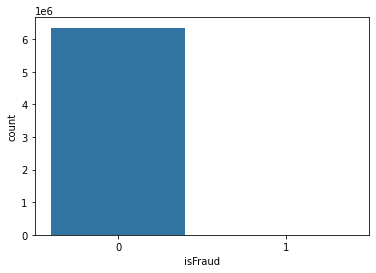

In [340]:
sns.countplot(df.isFraud)


In [341]:
df.isFraud.value_counts()


0    6354407
1       8213
Name: isFraud, dtype: int64

In [342]:
y = x.isFraud
y

2          1
3          1
15         0
19         0
24         0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 2770409, dtype: int64

In [343]:
x = x.drop(columns = ['isFraud'])

In [344]:
x

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,0


In [345]:
np.random.seed(3)
x

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,0


In [346]:
x = x.drop(columns = ['nameOrig', 'nameDest', 'isFlaggedFraud'])

In [347]:
x.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89


In [348]:
# converting categorical into numerical
# convert column type having TRANSFER and CASH_OUT into 0 & 1 encoding

x.type = pd.get_dummies(x.type)
x.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [349]:
# incase of fraud transaction the old and new balance is not updated, only the transaction shows the amount
# incase of non fraud transaction both old and new balance are updated, lets have a look

xfraud = x.loc[y == 1]
xnonfraud = x.loc[y == 0]

fraudpercent = len(xfraud.loc[(xfraud.oldBalanceDest == 0 ) &  (xfraud.newBalanceDest == 0) * xfraud.amount])/len(xfraud)
nonfraudpercent = len(xnonfraud.loc[(xnonfraud.oldBalanceDest == 0 ) &  (xnonfraud.newBalanceDest == 0) * xnonfraud.amount])/len(xnonfraud)


print("% of fraud transactions where old ad new balance doesn't get updated is : ",fraudpercent*100)
print("% of nonfraud transactions where old ad new balance doesn't get updated is : ", nonfraudpercent*100)

% of fraud transactions where old ad new balance doesn't get updated is :  49.55558261293072
% of nonfraud transactions where old ad new balance doesn't get updated is :  0.061762452773083454


### conclusion - 50% of fraudulent transactions don't update old and new balances in the destination accounts, where as only 0.06% of non-fraudulent transactions update old and new balances, this says that newBalanceDest being zero is a strong indicator or fraudulent transaction, hence we'll not impute the data but we'll replace it with -1 for our algorithm to be able to detect it more accurately.

In [350]:
x.loc[(x.oldBalanceDest == 0) & (x.newBalanceDest == 0) & (x.amount != 0), ['oldBalanceDest', 'newBalanceDest']] = -1
x

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.00,0.0,-1.00,-1.00
3,1,1,181.00,181.00,0.0,21182.00,0.00
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44
19,1,0,215310.30,705.00,0.0,22425.00,0.00
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13
6362616,743,0,6311409.28,6311409.28,0.0,-1.00,-1.00
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11
6362618,743,0,850002.52,850002.52,0.0,-1.00,-1.00


In [351]:
y

2          1
3          1
15         0
19         0
24         0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 2770409, dtype: int64

### there are also several transactions where old and new balance on non-zero transactions are zero in originating account, in this case we replace the values with null since their percentage is minimal and not to bias the data

In [352]:
x.loc[(x.oldBalanceOrig == 0) & (x.newBalanceOrig == 0) & (x.amount != 0), ['oldBalanceOrig', 'newBalanceOrig']] = np.nan
x

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.00,0.0,-1.00,-1.00
3,1,1,181.00,181.00,0.0,21182.00,0.00
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44
19,1,0,215310.30,705.00,0.0,22425.00,0.00
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13
6362616,743,0,6311409.28,6311409.28,0.0,-1.00,-1.00
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11
6362618,743,0,850002.52,850002.52,0.0,-1.00,-1.00


### we record the error in the transactions by creating two new columns, in order to record fraudulent transaction giving strength to our model.



In [353]:
x['errorBalanceOrig'] = x.newBalanceOrig + x.amount - x.oldBalanceOrig
x['errorBalanceDest'] = x.oldBalanceDest + x.amount - x.newBalanceDest
x

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.00,0.0,-1.00,-1.00,0.00,1.810000e+02
3,1,1,181.00,181.00,0.0,21182.00,0.00,0.00,2.136300e+04
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44,213808.94,1.827035e+05
19,1,0,215310.30,705.00,0.0,22425.00,0.00,214605.30,2.377353e+05
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89,300850.89,-2.401220e+06
...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,0.00,0.000000e+00
6362616,743,0,6311409.28,6311409.28,0.0,-1.00,-1.00,0.00,6.311409e+06
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,0.00,1.000000e-02
6362618,743,0,850002.52,850002.52,0.0,-1.00,-1.00,0.00,8.500025e+05


In [354]:
# split into training and testing


from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 3)

### XGBoost algorithm

In [355]:
# Long computation in this cell (~1.8 minutes)
weights = (y == 0).sum() / (1.0 * (y == 1).sum())

clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)

probabilities = clf.fit(xtrain, ytrain).predict_proba(xtest)
print('AUPRC = {}'.format(average_precision_score(ytest, probabilities[:, 1])))

AUPRC = 0.9976319099826547


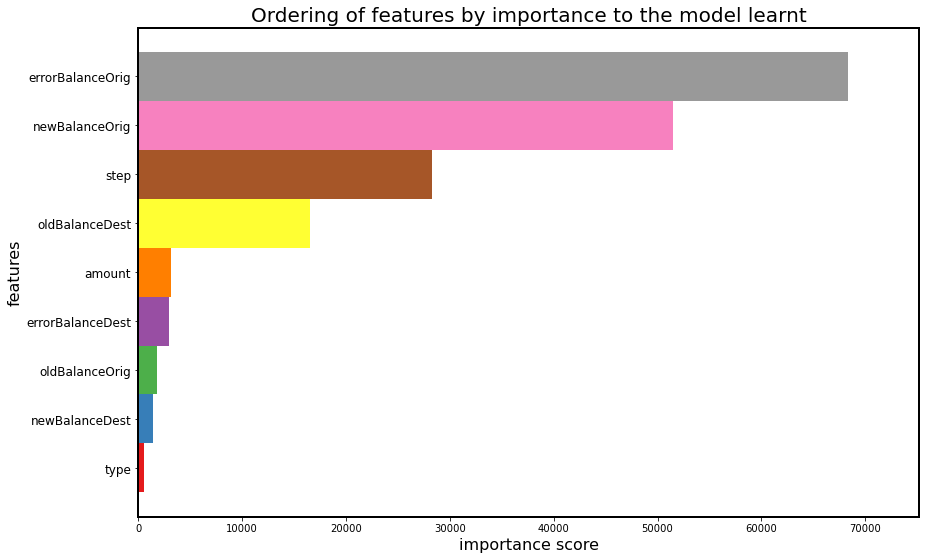

In [356]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [357]:
ypred = clf.predict(xtest)

In [358]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

cmXGBoost = confusion_matrix(ytest, ypred)
cmXGBoost

array([[552364,     25],
       [     6,   1687]])

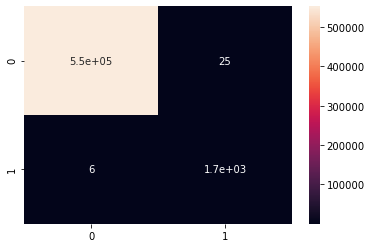

In [359]:
sns.heatmap(cmXGBoost, annot = True)

In [360]:
acc = accuracy_score(ytest, ypred)
prec = precision_score(ytest, ypred)
rec = recall_score(ytest, ypred)
f1 = f1_score(ytest, ypred)

In [361]:
results = pd.DataFrame([['XGBoost', acc, prec, rec, f1]],
            columns = ["Model", 'accuray', 'precision' , 'recall', 'f1 score'])

In [362]:
results

,Model,accuray,precision,recall,f1 score
0,XGBoost,0.999944,0.985397,0.996456,0.990896


### Logistic Regression

In [363]:
xtrain.isna().sum()


step                      0
type                      0
amount                    0
oldBalanceOrig      1046892
newBalanceOrig      1046892
oldBalanceDest            0
newBalanceDest            0
errorBalanceOrig    1046892
errorBalanceDest          0
dtype: int64

In [364]:
xtrain = xtrain.fillna(0)
xtest = xtest.fillna(0)

In [365]:
lr = LogisticRegression(random_state = 0, penalty = 'l2')
lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [366]:
ypred = lr.predict(xtest)

In [367]:
acc = accuracy_score(ytest, ypred)
prec = precision_score(ytest, ypred)
rec = recall_score(ytest, ypred)
f1 = f1_score(ytest, ypred)

model_results = pd.DataFrame([['Logistic Regression', acc, prec, rec, f1]],
            columns = ["Model", 'accuray', 'precision' , 'recall', 'f1 score'])

results = results.append(model_results, ignore_index = True)

In [368]:
#results = results.loc[(results.index !=1)]

In [369]:
results

,Model,accuray,precision,recall,f1 score
0,XGBoost,0.999944,0.985397,0.996456,0.990896
1,Logistic Regression,0.996802,0.472964,0.408151,0.438174


In [370]:
cmLR = confusion_matrix(ytest, ypred)
cmLR

array([[551619,    770],
       [  1002,    691]])

### Random forest

In [371]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators= 20)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [372]:
ypred = rf.predict(xtest)


In [373]:
acc = accuracy_score(ytest, ypred)
prec = precision_score(ytest, ypred)
rec = recall_score(ytest, ypred)
f1 = f1_score(ytest, ypred)

model_results = pd.DataFrame([['Random Forest', acc, prec, rec, f1]],
            columns = ["Model", 'accuray', 'precision' , 'recall', 'f1 score'])

results = results.append(model_results, ignore_index = True)

In [374]:
results

,Model,accuray,precision,recall,f1 score
0,XGBoost,0.999944,0.985397,0.996456,0.990896
1,Logistic Regression,0.996802,0.472964,0.408151,0.438174
2,Random Forest,0.999982,0.998814,0.995275,0.997041


In [375]:
cmRF = confusion_matrix(ytest, ypred)
cmRF

array([[552387,      2],
       [     8,   1685]])

### Confusion matrix

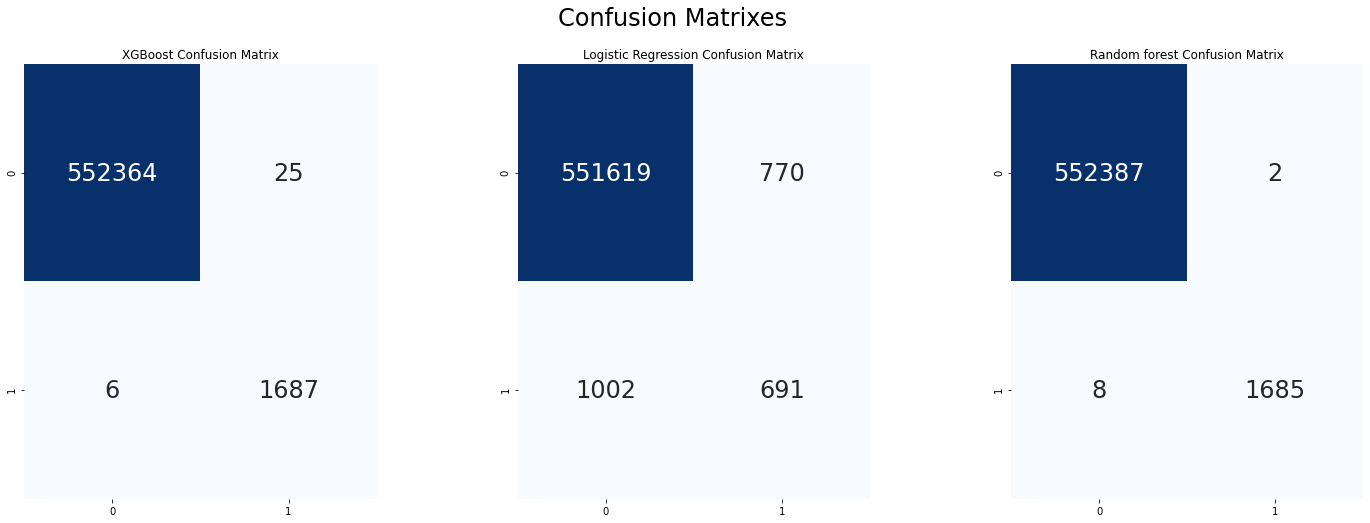

In [379]:
plt.figure(figsize=(24,8))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(1,3,1)
plt.title("XGBoost Confusion Matrix")
sns.heatmap(cmXGBoost,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(1,3,2)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cmLR,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(1,3,3)
plt.title("Random forest Confusion Matrix")
sns.heatmap(cmRF,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})


plt.show()

In [380]:
results

,Model,accuray,precision,recall,f1 score
0,XGBoost,0.999944,0.985397,0.996456,0.990896
1,Logistic Regression,0.996802,0.472964,0.408151,0.438174
2,Random Forest,0.999982,0.998814,0.995275,0.997041
